## Load documents with IDs

In [14]:
import json

with open('/app/Law_corpus/documents-with-ids.json', 'rt') as f_in:  # Use /app, not the Windows path
    documents = json.load(f_in)

In [15]:
documents[10]

{'law_title': 'Luật Giáo Dục',
 'law_number': 'Luật số: 43/2019/QH14',
 'chapter_title': 'Chương I',
 'article_number': 'Điều 11',
 'title': 'Ngôn ngữ, chữ viết dùng trong cơ sở giáo dục',
 'content': '1. Tiếng Việt là ngôn ngữ chính thức dùng trong cơ sở giáo dục. Căn cứ vào mục tiêu giáo dục và yêu cầu cụ thể về nội dung giáo dục, Chính phủ quy định việc dạy và học bằng tiếng nước ngoài trong cơ sở giáo dục. 2. Nhà nước khuyến khích, tạo điều kiện để người dân tộc thiểu số được học tiếng nói, chữ viết của dân tộc mình theo quy định của Chính phủ; người khuyết tật nghe, nói được học bằng ngôn ngữ ký hiệu, người khuyết tật nhìn được học bằng chữ nổi Braille theo quy định của Luật Người khuyết tật. 3. Ngoại ngữ quy định trong chương trình giáo dục là ngôn ngữ được sử dụng phổ biến trong giao dịch quốc tế. Việc tổ chức dạy ngoại ngữ trong cơ sở giáo dục phải bảo đảm để người học được học liên tục, hiệu quả. ',
 'id': '1095c99a'}

## Load ground truth

In [16]:
import pandas as pd

df_ground_truth = pd.read_csv('./evaluate/ground-truth-data.csv')
ground_truth = df_ground_truth.to_dict(orient='records')

In [17]:
ground_truth[10]

{'questions': 'Nền giáo dục Việt Nam có đặc điểm gì nổi bật?',
 'law_title': 'Luật Giáo Dục',
 'document': 'e0e71ffa'}

In [18]:
doc_idx = {d['id']: d for d in documents}
doc_idx['e0e71ffa']

{'law_title': 'Luật Giáo Dục',
 'law_number': 'Luật số: 43/2019/QH14',
 'chapter_title': 'Chương I',
 'article_number': 'Điều 3',
 'title': 'Tính chất, nguyên lý giáo dục',
 'content': '1. Nền giáo dục Việt Nam là nền giáo dục xã hội chủ nghĩa có tính nhân dân, dân tộc, khoa học, hiện đại, lấy chủ nghĩa Mác - Lê nin và tư tưởng Hồ Chí Minh làm nền tảng. 2. Hoạt động giáo dục được thực hiện theo nguyên lý học đi đôi với hành, lý luận gắn liền với thực tiễn, giáo dục nhà trường kết hợp với giáo dục gia đình và giáo dục xã hội. ',
 'id': 'e0e71ffa'}

## Index data

In [19]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("truro7/vn-law-embedding", truncate_dim = 768) #truncate_dim = 768

Invalid model-index. Not loading eval results into CardData.
Invalid model-index. Not loading eval results into CardData.


In [20]:
from elasticsearch import Elasticsearch
# es_client = Elasticsearch('http://localhost:9200') 
es_client = Elasticsearch('http://elasticsearch_compose:9200') #connect to docker compose network if runinng from dockerfile container 
# es_client.info()

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "law_title": {"type": "keyword"},                
            "law_number": {"type": "keyword"},               
            "chapter_title": {"type": "keyword"},            
            "article_number": {"type": "keyword"},            
            "title": {"type": "text"},                        
            "content": {"type": "text"},   
            "id": {"type": "text"},   
            "title_content_vector": {                                 
                "type": "dense_vector",
                "dims": 768,                                 
                "index": True,
                "similarity": "cosine"
            }                
        }
    }
}

index_name = "legal_documents_ids"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'legal_documents_ids'})

In [21]:
documents[10]

{'law_title': 'Luật Giáo Dục',
 'law_number': 'Luật số: 43/2019/QH14',
 'chapter_title': 'Chương I',
 'article_number': 'Điều 11',
 'title': 'Ngôn ngữ, chữ viết dùng trong cơ sở giáo dục',
 'content': '1. Tiếng Việt là ngôn ngữ chính thức dùng trong cơ sở giáo dục. Căn cứ vào mục tiêu giáo dục và yêu cầu cụ thể về nội dung giáo dục, Chính phủ quy định việc dạy và học bằng tiếng nước ngoài trong cơ sở giáo dục. 2. Nhà nước khuyến khích, tạo điều kiện để người dân tộc thiểu số được học tiếng nói, chữ viết của dân tộc mình theo quy định của Chính phủ; người khuyết tật nghe, nói được học bằng ngôn ngữ ký hiệu, người khuyết tật nhìn được học bằng chữ nổi Braille theo quy định của Luật Người khuyết tật. 3. Ngoại ngữ quy định trong chương trình giáo dục là ngôn ngữ được sử dụng phổ biến trong giao dịch quốc tế. Việc tổ chức dạy ngoại ngữ trong cơ sở giáo dục phải bảo đảm để người học được học liên tục, hiệu quả. ',
 'id': '1095c99a'}

In [22]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    title = doc['title']
    content = doc['content']
    doc['title_content_vector'] = model.encode(title + ' ' + content)

    es_client.index(index=index_name, document=doc)

  0%|          | 0/314 [00:00<?, ?it/s]

## Retrieval

In [63]:
def elastic_search_knn(field, vector, law_title):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 3,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "law_title": law_title
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["law_title", "law_number", "chapter_title", "article_number", "title", "content","id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def title_content_vector_knn(q):
    questions = q['questions']
    law_title = q['law_title']

    v_q = model.encode(questions)

    return elastic_search_knn('title_content_vector', v_q, law_title)


In [24]:
title_content_vector_knn(ground_truth[1])

[{'article_number': 'Điều 82',
  'law_number': 'Luật số: 43/2019/QH14',
  'chapter_title': 'Chương V',
  'id': '2fa13653',
  'title': 'Nhiệm vụ của người học',
  'law_title': 'Luật Giáo Dục',
  'content': '1. Học tập, rèn luyện theo chương trình, kế hoạch giáo dục, quy tắc ứng xử của cơ sở giáo dục. 2. Tôn trọng nhà giáo, cán bộ và người lao động của cơ sở giáo dục; đoàn kết, giúp đỡ lẫn nhau trong học tập, rèn luyện; thực hiện nội quy, điều lệ, quy chế của cơ sở giáo dục; chấp hành quy định của pháp luật. 3. Tham gia lao động và hoạt động xã hội, hoạt động bảo vệ môi trường phù hợp với lứa tuổi, sức khỏe và năng lực. 4. Giữ gìn, bảo vệ tài sản của cơ sở giáo dục. 5. Góp phần xây dựng, bảo vệ và phát huy truyền thống của cơ sở giáo dục. '}]

## The RAG flow

In [25]:
def build_prompt(query, search_results):
    prompt_template = """
You're a law searcher assistant. Answer the QUESTION based on the CONTEXT from the law database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT:
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context += f"law_title: {doc['law_title']}\nlaw_number: {doc['law_number']}\narticle_number: {doc['article_number']}\ntitle: {doc['title']}\ncontent: {doc['content']}\n\n"

    # prompt_template = """CONTEXT:\n{context}\n\nQUESTION: {question}""".strip()
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt



In [52]:
import re
import time
from googletrans import Translator

translator = Translator()

def clean_text(text):
    """
    Cleans text by removing non-printable characters, normalizing whitespace,
    and specifically handling problematic semicolons.
    """
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with single spaces
    text = ''.join(c for c in text if c.isprintable())  # Remove non-printable characters
    text = text.replace(';', ',')  # Replace semicolons with commas
    return text

def undo_clean_text(text):
    """
    Reverses the semicolon replacement done by clean_text.
    """
    text = text.replace(',', ';')  # Replace commas back to semicolons
    return text

def translate_in_chunks(text, chunk_size=4000):
    """
    Translates text in smaller chunks to avoid potential issues with large text.
    """
    if len(text) <= chunk_size:
        return vietnamese_to_italian(text)

    chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]
    translated_chunks = [vietnamese_to_italian(chunk) for chunk in chunks]
    return " ".join(translated_chunks)

def vietnamese_to_italian(text):
    """
    Translates Vietnamese text to Italian using the googletrans library.
    Handles potential None values returned by the translator.
    """
    try:
        if text is None:  # Check for None input
            return ""
        translation = translator.translate(text, src='vi', dest='it')
        if translation is None:  # Check for None translation result
            return ""
        return translation.text
    except Exception as e:
        print(f"An error occurred during translation: {e}")
        return ""

def italian_to_vietnamese(text):
    """
    Translates Italian text to Vietnamese using the googletrans library.
    Handles potential None values returned by the translator.
    """
    try:
        if text is None:  # Check for None input
            return ""
        translation = translator.translate(text, src='it', dest='vi')
        if translation is None:  # Check for None translation result
            return ""
        return translation.text
    except Exception as e:
        print(f"An error occurred during translation: {e}")
        return ""

def build_prompt(query, search_results):
    prompt_template = """
Sei un assistente di ricerca legale. Rispondi alla DOMANDA basandoti sul CONTESTO del database legale.
Utilizza solo i fatti dal CONTESTO quando rispondi alla DOMANDA.

CONTESTO:
{context}
""".strip()

    # Translate the query to Italian
    translated_query = vietnamese_to_italian(query)

    context = ""
    for doc in search_results:
        # Translate each field, cleaning the text first
        translated_law_title = vietnamese_to_italian(clean_text(doc['law_title']))

        translated_title = vietnamese_to_italian(clean_text(doc['title']))

        # Translate content in chunks, cleaning it first
        translated_content = translate_in_chunks(clean_text(doc['content']))

        # Reverse the semicolon replacement in the translated content
        translated_content = undo_clean_text(translated_content)

        context += f"titolo di legge: {translated_law_title}\n titolo: {translated_title}\n legge: {translated_content}"

    # Use the correct key 'question' here
    prompt = prompt_template.format(question=translated_query, context=context).strip()
    return prompt

In [28]:
context = build_prompt(ground_truth[0], title_content_vector_knn(ground_truth[0]))
context

An error occurred during translation: the JSON object must be str, bytes or bytearray, not NoneType


"Sei un assistente di ricerca legale. Rispondi alla DOMANDA basandoti sul CONTESTO del database legale.\nUtilizza solo i fatti dal CONTESTO quando rispondi alla DOMANDA.\n\nDOMANDA: \n\nCONTESTO:\ntitolo_legge: Legge sull'istruzione\nnumero_legge: Legge n. 43/2019/QH14\nnumero_articolo: Articolo 1\ntitolo: Ambito di regolazione\ncontenuto: Questa legge stabilisce il sistema educativo nazionale; le istituzioni educative; gli insegnanti; gli studenti; la gestione dello stato dell'istruzione; i diritti e le responsabilità di agenzie; organizzazioni e individui legati agli insegnanti."

In [29]:
print(italian_to_vietnamese(context))

Bạn là một trợ lý nghiên cứu pháp lý.Trả lời câu hỏi dựa trên bối cảnh của cơ sở dữ liệu pháp lý.
Chỉ sử dụng các sự kiện từ bối cảnh khi bạn trả lời câu hỏi.

LỜI YÊU CẦU:

BỐI CẢNH:
Tiêu đề_legge: Luật giáo dục
Number_legge: Luật số.43/2019/QH14
Number_ Bài báo: Điều 1
Tiêu đề: Khu vực quy định
Nội dung: Luật này thiết lập hệ thống giáo dục quốc gia;các tổ chức giáo dục;giáo viên;sinh viên;quản lý nhà nước giáo dục;các quyền và trách nhiệm của các cơ quan;Các tổ chức và cá nhân liên kết với giáo viên.


In [30]:
from transformers import MambaConfig, MambaForCausalLM, AutoTokenizer
import torch

mamba_model_name = "DeepMount00/mamba_790_hf_qa"
mamba_tokenizer = AutoTokenizer.from_pretrained(mamba_model_name)
mamba_model = MambaForCausalLM.from_pretrained(mamba_model_name, device_map={"": 0}).eval()

tokenizer_config.json:   0%|          | 0.00/4.79k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/921 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.17G [00:00<?, ?B/s]

The fast path is not available because one of `(selective_state_update, selective_scan_fn, causal_conv1d_fn, causal_conv1d_update, mamba_inner_fn)` is None. Falling back to the sequential implementation of Mamba, as use_mambapy is set to False. To install follow https://github.com/state-spaces/mamba/#installation and https://github.com/Dao-AILab/causal-conv1d. For the mamba.py backend, follow https://github.com/alxndrTL/mamba.py.


generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

In [53]:
def llm(context, question):
    device = "cuda:0"
    # Hybrid prefix: Start with the working Italian, then transition to English instructions

    prompt = f""" ##CONTESTO: {context}\n##DOMANDA: {question}\n"""

    input_ids = mamba_tokenizer([prompt], return_tensors="pt").to(device)

    generate_ids = mamba_model.generate(**input_ids, max_new_tokens=300, eos_token_id=8112)

    answer = mamba_tokenizer.batch_decode(generate_ids)

    try:
        final_answer = answer[0].split("##RISPOSTA: ")[1].split("##END")[0].strip("\n")
    except IndexError:
        final_answer = ""
    return final_answer

In [78]:
def format_search_results(search_results):
    """
    Formats the search results into a readable string.

    Args:
        search_results (list): A list of dictionaries, where each dictionary is a search result.

    Returns:
        str: The formatted search results string.
    """
    formatted_results = ""
    for doc in search_results:
        formatted_results += (
            f"{doc['law_title']}\n"
            f"{doc['law_number']}\n"
            f"{doc['article_number']}\n"
            f"{doc['title']}\n"
            f"{doc['content']}\n\n"
        )
    return formatted_results.strip()

def rag(query: str) -> str:
    search_results = title_content_vector_knn(query)

    # Translate the query to Italian before passing it to build_prompt
    translated_query = vietnamese_to_italian(ground_truth[1]['questions'] if isinstance(ground_truth[1], dict) and 'questions' in ground_truth[1] else "")

    context = build_prompt(translated_query, search_results)  # Context is built using the translated query

    answer = llm(context, translated_query)

    # Combine the formatted search results and translated answer with a newline separator
    return italian_to_vietnamese(answer)

def rag_with_search(query: str) -> str:
    search_results = title_content_vector_knn(query)
    search_results_str = format_search_results(search_results)

    # Translate the query to Italian before passing it to build_prompt
    translated_query = vietnamese_to_italian(ground_truth[1]['questions'] if isinstance(ground_truth[1], dict) and 'questions' in ground_truth[1] else "")

    context = build_prompt(translated_query, search_results)  # Context is built using the translated query

    answer = llm(context, translated_query)

    # Combine the formatted search results and translated answer with a newline separator
    return print(f"{search_results_str}\n\n DeepMount00/mamba_790_hf_qa:{italian_to_vietnamese(answer)}")

In [58]:
ground_truth[1]

{'questions': 'Những quyền và trách nhiệm nào của cá nhân liên quan đến hoạt động giáo dục được quy định trong Luật này?',
 'law_title': 'Luật Giáo Dục',
 'document': '75a9286e'}

In [80]:
rag(ground_truth[1])

'Học sinh chịu trách nhiệm về an toàn cho việc học tập, đào tạo, nghiên cứu và thúc đẩy truyền thống của các tổ chức giáo dục.'

In [79]:
rag_with_search(ground_truth[1])

Luật Giáo Dục
Luật số: 43/2019/QH14
Điều 82
Nhiệm vụ của người học
1. Học tập, rèn luyện theo chương trình, kế hoạch giáo dục, quy tắc ứng xử của cơ sở giáo dục. 2. Tôn trọng nhà giáo, cán bộ và người lao động của cơ sở giáo dục; đoàn kết, giúp đỡ lẫn nhau trong học tập, rèn luyện; thực hiện nội quy, điều lệ, quy chế của cơ sở giáo dục; chấp hành quy định của pháp luật. 3. Tham gia lao động và hoạt động xã hội, hoạt động bảo vệ môi trường phù hợp với lứa tuổi, sức khỏe và năng lực. 4. Giữ gìn, bảo vệ tài sản của cơ sở giáo dục. 5. Góp phần xây dựng, bảo vệ và phát huy truyền thống của cơ sở giáo dục. 

Luật Giáo Dục
Luật số: 43/2019/QH14
Điều 89
Trách nhiệm của nhà trường
1. Nhà trường có trách nhiệm thực hiện kế hoạch phổ cập giáo dục, quy tắc ứng xử; chủ động phối hợp với gia đình và xã hội để tổ chức hoặc tham gia các hoạt động giáo dục theo kế hoạch của nhà trường, bảo đảm an toàn cho người dạy và người học; thông báo về kết quả học tập, rèn luyện của học sinh cho cha mẹ hoặc người

In [82]:
doc_idx['75a9286e']

{'law_title': 'Luật Giáo Dục',
 'law_number': 'Luật số: 43/2019/QH14',
 'chapter_title': 'Chương I',
 'article_number': 'Điều 1',
 'title': 'Phạm vi điều chỉnh',
 'content': 'Luật này quy định về hệ thống giáo dục quốc dân; cơ sở giáo dục, nhà giáo, người học; quản lý nhà nước về giáo dục; quyền và trách nhiệm của cơ quan, tổ chức, cá nhân liên quan đến hoạt động giáo dục. ',
 'id': '75a9286e',
 'title_content_vector': array([-1.97882224e-02, -1.99339297e-02,  4.56860475e-02,  8.96888971e-02,
        -5.92795312e-02, -6.35427088e-02,  4.05403003e-02,  1.20414663e-02,
         1.30230516e-01,  3.74822877e-02,  7.43912440e-03,  8.62386171e-03,
         4.33983728e-02,  2.53979526e-02,  1.36169503e-02, -1.71789490e-02,
         6.61228448e-02,  7.36672133e-02, -5.86116761e-02,  9.18327495e-02,
        -1.52075256e-03,  4.18600067e-02,  3.99471521e-02,  8.13104771e-03,
         2.45093219e-02,  8.91548989e-05,  2.86348090e-02, -6.75837044e-03,
         1.57178324e-02,  5.52585609e-02,  1.1

## Cosine similarity metric

In [39]:
law_content = 'Những quyền và trách nhiệm nào của cá nhân liên quan đến hoạt động giáo dục được quy định trong Luật này?'

answer_llm = 'Học sinh chịu trách nhiệm về an toàn cho việc học tập, đào tạo, nghiên cứu và thúc đẩy truyền thống của các tổ chức giáo dục.'


v_llm = model.encode(answer_llm)
v_orig = model.encode(law_content)

v_llm.dot(v_orig)

np.float32(-0.05068712)

In [86]:
ground_truth[0]

{'questions': 'Luật Giáo Dục điều chỉnh những đối tượng nào trong hệ thống giáo dục quốc dân?',
 'law_title': 'Luật Giáo Dục',
 'document': '75a9286e'}

In [87]:
print(len(ground_truth))
import random

# Assuming ground_truth is a list of dictionaries
ground_truth_llm = random.sample(ground_truth, 500)

print(len(ground_truth_llm))

1570
500


In [61]:
answers = {}

In [89]:
for i, rec in enumerate(tqdm(ground_truth_llm)):
    if i in answers:
        continue

    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    law_content = original_doc['content']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': law_content,
        'document': doc_id,
        'questions': rec['questions'],
        'law_title': rec['law_title'],
    }

  0%|          | 0/500 [00:00<?, ?it/s]

An error occurred during translation: Invalid input ConnectionInputs.RECV_PING in state ConnectionState.CLOSED
An error occurred during translation: the JSON object must be str, bytes or bytearray, not NoneType
An error occurred during translation: the JSON object must be str, bytes or bytearray, not NoneType
An error occurred during translation: the JSON object must be str, bytes or bytearray, not NoneType
An error occurred during translation: the JSON object must be str, bytes or bytearray, not NoneType
An error occurred during translation: the JSON object must be str, bytes or bytearray, not NoneType
An error occurred during translation: the JSON object must be str, bytes or bytearray, not NoneType
An error occurred during translation: the JSON object must be str, bytes or bytearray, not NoneType
An error occurred during translation: the JSON object must be str, bytes or bytearray, not NoneType
An error occurred during translation: the JSON object must be str, bytes or bytearray, no

In [90]:
len(answers)

500

In [91]:
answers.values()

dict_values([{'answer_llm': 'Các văn bản không cung cấp một phản hồi cụ thể.', 'answer_orig': 'Anh, chị, em có quyền, nghĩa vụ thương yêu, chăm sóc, giúp đỡ nhau; có quyền, nghĩa vụ nuôi dưỡng nhau trong trường hợp không còn cha mẹ hoặc cha mẹ không có điều kiện trông nom, nuôi dưỡng, chăm sóc, giáo dục con. ', 'document': '53603883', 'questions': 'Quyền của anh, chị, em trong gia đình là gì?', 'law_title': 'Luật Hôn Nhân Và Gia Đình'}, {'answer_llm': 'Không có câu trả lời trong bối cảnh', 'answer_orig': '1. Người điều khiển xe đạp chỉ được chở một người, trừ trường hợp chở thêm một trẻ em dưới 7 tuổi thì được chở tối đa hai người. Người điều khiển xe đạp phải thực hiện quy định tại khoản 3 Điều 30 của Luật này; người ngồi trên xe đạp khi tham gia giao thông phải thực hiện quy định tại khoản 4 Điều 30 của Luật này. 2. Người điều khiển, người ngồi trên xe đạp máy phải đội mũ bảo hiểm có cài quai đúng quy cách. 3. Người điều khiển xe thô sơ khác phải cho xe đi hàng một, nơi có phần đường

In [96]:
df = pd.DataFrame(answers.values())
df.to_csv("DeepMount00_mamba_790_hf_qa.csv", index=False)


In [94]:
results_mamba_qa = [None] * len(ground_truth)

for i, val in answers.items():
    results_mamba_qa[i] = val.copy()
    results_mamba_qa[i].update(ground_truth[i])

In [100]:
results_mamba_qa

[{'answer_llm': 'Các văn bản không cung cấp một phản hồi cụ thể.',
  'answer_orig': 'Anh, chị, em có quyền, nghĩa vụ thương yêu, chăm sóc, giúp đỡ nhau; có quyền, nghĩa vụ nuôi dưỡng nhau trong trường hợp không còn cha mẹ hoặc cha mẹ không có điều kiện trông nom, nuôi dưỡng, chăm sóc, giáo dục con. ',
  'document': '75a9286e',
  'questions': 'Luật Giáo Dục điều chỉnh những đối tượng nào trong hệ thống giáo dục quốc dân?',
  'law_title': 'Luật Giáo Dục'},
 {'answer_llm': 'Không có câu trả lời trong bối cảnh',
  'answer_orig': '1. Người điều khiển xe đạp chỉ được chở một người, trừ trường hợp chở thêm một trẻ em dưới 7 tuổi thì được chở tối đa hai người. Người điều khiển xe đạp phải thực hiện quy định tại khoản 3 Điều 30 của Luật này; người ngồi trên xe đạp khi tham gia giao thông phải thực hiện quy định tại khoản 4 Điều 30 của Luật này. 2. Người điều khiển, người ngồi trên xe đạp máy phải đội mũ bảo hiểm có cài quai đúng quy cách. 3. Người điều khiển xe thô sơ khác phải cho xe đi hàng m

In [93]:
import pandas as pd

In [99]:
df_mamba_qa = pd.read_csv("./DeepMount00_mamba_790_hf_qa.csv")
df_mamba_qa

,answer_llm,answer_orig,document,questions,law_title
0,Các văn bản không cung cấp một phản hồi cụ thể.,"Anh, chị, em có quyền, nghĩa vụ thương yêu, ch...",53603883,"Quyền của anh, chị, em trong gia đình là gì?",Luật Hôn Nhân Và Gia Đình
1,Không có câu trả lời trong bối cảnh,1. Người điều khiển xe đạp chỉ được chở một ng...,183e54d8,Ai được phép chở trên xe đạp theo quy định của...,Luật Giao Thông Đường Bộ
2,Chính phủ ban hành một hệ thống giáo dục quốc ...,1. Văn bằng của hệ thống giáo dục quốc dân đượ...,62fe6274,Chính phủ có quy định gì về hệ thống văn bằng ...,Luật Giáo Dục
3,"Cha mẹ có quyền chăm sóc, giáo dục, quản lý và...",1. Trong trường hợp cha hoặc mẹ bị Tòa án hạn ...,7077e01f,Ai sẽ thực hiện quyền nuôi dưỡng và chăm sóc c...,Luật Hôn Nhân Và Gia Đình
4,Mọi người được đảm bảo cho việc học tập vĩnh v...,Cơ sở giáo dục phổ thông bao gồm: 1. Trường ti...,7bcff432,Trường tiểu học là loại cơ sở giáo dục nào?,Luật Giáo Dục
...,...,...,...,...,...
495,Tôi không đủ thông tin để trả lời câu hỏi này.,"1. Nam, nữ có đủ điều kiện kết hôn theo quy đị...",5d674582,"Nếu nam, nữ không đăng ký kết hôn thì quyền và...",Luật Hôn Nhân Và Gia Đình
496,Cha mẹ có quyền giáo dục con cái và đóng góp c...,"Việc trông nom, chăm sóc, nuôi dưỡng, giáo dục...",63ecff26,Luật nào quy định về giáo dục con cái sau khi ...,Luật Hôn Nhân Và Gia Đình
497,Các văn bản không cung cấp một câu trả lời cụ ...,"1. Nội dung giáo dục phải bảo đảm tính cơ bản,...",970cc3cd,Luật Giáo Dục quy định như thế nào về việc cập...,Luật Giáo Dục
498,Tôi không đủ thông tin để trả lời câu hỏi này.,"Việc xác lập, thực hiện, chấm dứt các giao dịc...",61a9776e,"Nếu nhà ở không đảm bảo chỗ ở cho vợ chồng, có...",Luật Hôn Nhân Và Gia Đình


## Evaluating GPT 3.5

In [ ]:
rag(ground_truth[10], model='gpt-3.5-turbo')

In [ ]:
from tqdm.auto import tqdm

from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=6)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [ ]:
def process_record(rec):
    model = 'gpt-3.5-turbo'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [ ]:
process_record(ground_truth[10])

In [ ]:
results_gpt35 = map_progress(pool, ground_truth, process_record)

In [ ]:
df_gpt35 = pd.DataFrame(results_gpt35)
df_gpt35.to_csv('data/results-gpt35.csv', index=False)

In [ ]:
!head data/results-gpt35.csv

## Cosine similarity

A->Q->A' cosine similarity

A -> Q -> A'

cosine(A, A')

### gpt-4o

In [101]:
results_mamba_qa = df_mamba_qa.to_dict(orient='records')

In [103]:
record = results_mamba_qa[0]
record

{'answer_llm': 'Các văn bản không cung cấp một phản hồi cụ thể.',
 'answer_orig': 'Anh, chị, em có quyền, nghĩa vụ thương yêu, chăm sóc, giúp đỡ nhau; có quyền, nghĩa vụ nuôi dưỡng nhau trong trường hợp không còn cha mẹ hoặc cha mẹ không có điều kiện trông nom, nuôi dưỡng, chăm sóc, giáo dục con. ',
 'document': '53603883',
 'questions': 'Quyền của anh, chị, em trong gia đình là gì?',
 'law_title': 'Luật Hôn Nhân Và Gia Đình'}

In [109]:
def compute_similarity(record):
    answer_orig = str(record['answer_orig'])  # Convert to string
    answer_llm = str(record['answer_llm'])    # Convert to string
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    return v_llm.dot(v_orig)

In [113]:
answer_llm

'Tôi không đủ thông tin để trả lời câu hỏi này.'

In [111]:
similarity = []

for record in tqdm(results_mamba_qa):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|          | 0/500 [00:00<?, ?it/s]

In [112]:
df_mamba_qa['cosine'] = similarity
df_mamba_qa['cosine'].describe()

count    500.000000
mean       0.285261
std        0.276455
min       -0.256527
25%        0.038273
50%        0.210882
75%        0.533274
max        0.878022
Name: cosine, dtype: float64

In [114]:
import seaborn as sns

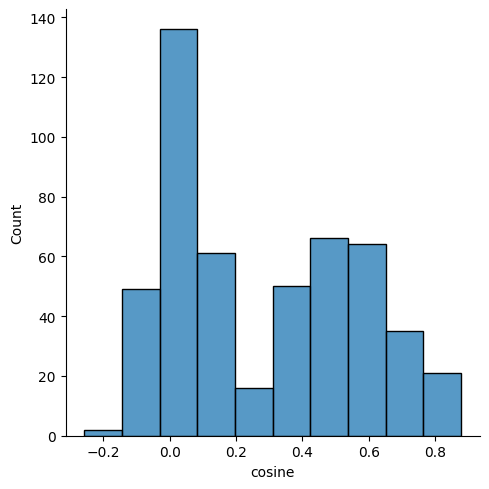

In [122]:
sns.displot(df_mamba_qa['cosine'])

### gpt-3.5-turbo

In [ ]:
results_gpt35 = df_gpt35.to_dict(orient='records')

similarity_35 = []

for record in tqdm(results_gpt35):
    sim = compute_similarity(record)
    similarity_35.append(sim)

In [ ]:
df_gpt35['cosine'] = similarity_35
df_gpt35['cosine'].describe()

In [ ]:
import matplotlib.pyplot as plt

### gpt-4o-mini

In [ ]:
def process_record_4o_mini(rec):
    model = 'gpt-4o-mini'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [ ]:
process_record_4o_mini(ground_truth[10])

In [ ]:
results_gpt4omini = []

In [ ]:
for record in tqdm(ground_truth):
    result = process_record_4o_mini(record)
    results_gpt4omini.append(result)

In [ ]:
df_gpt4o_mini = pd.DataFrame(results_gpt4omini)
df_gpt4o_mini.to_csv('data/results-gpt4o-mini.csv', index=False)

In [ ]:
similarity_4o_mini = []

for record in tqdm(results_gpt4omini):
    sim = compute_similarity(record)
    similarity_4o_mini.append(sim)

In [ ]:
df_gpt4o_mini['cosine'] = similarity_4o_mini
df_gpt4o_mini['cosine'].describe()

gpt4o 

```
count    1830.000000
mean        0.679129
std         0.217995
min        -0.153426
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995339
Name: cosine, dtype: float64
```

In [ ]:
# sns.distplot(df_gpt35['cosine'], label='3.5')

sns.distplot(df_mamba_qa['cosine'], label='4o')
sns.distplot(df_gpt4o_mini['cosine'], label='4o-mini')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

## LLM-as-a-Judge

In [ ]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [ ]:
df_sample = df_gpt4o_mini.sample(n=150, random_state=1)

In [ ]:
samples = df_sample.to_dict(orient='records')

In [ ]:
record = samples[0]
record

In [ ]:
prompt = prompt1_template.format(**record)
print(prompt)

In [ ]:
answer = llm(prompt, model='gpt-4o-mini')

In [ ]:
import json

In [ ]:
evaluations = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations.append(evaluation)

In [ ]:
json_evaluations = []

for i, str_eval in enumerate(evaluations):
    json_eval = json.loads(str_eval)
    json_evaluations.append(json_eval)

In [ ]:
df_evaluations = pd.DataFrame(json_evaluations)

In [ ]:
df_evaluations.Relevance.value_counts()

In [ ]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT'] #.to_dict(orient='records')

In [ ]:
sample[4]

In [ ]:
prompt = prompt2_template.format(**record)
print(prompt)

In [ ]:
evaluation = llm(prompt, model='gpt-4o-mini')
print(evaluation)

In [ ]:
evaluations_2 = []

for record in tqdm(samples):
    prompt = prompt2_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations_2.append(evaluation)

In [ ]:
json_evaluations_2 = []

for i, str_eval in enumerate(evaluations_2):
    json_eval = json.loads(str_eval)
    json_evaluations_2.append(json_eval)

In [ ]:
df_evaluations_2 = pd.DataFrame(json_evaluations_2)

In [ ]:
df_evaluations_2[df_evaluations_2.Relevance == 'NON_RELEVANT']

In [ ]:
samples[45]

## Saving all the data

In [ ]:
df_mamba_qa.to_csv('data/results-gpt4o-cosine.csv', index=False)
df_gpt35.to_csv('data/results-gpt35-cosine.csv', index=False)
df_gpt4o_mini.to_csv('data/results-gpt4o-mini-cosine.csv', index=False)

In [ ]:
df_evaluations.to_csv('data/evaluations-aqa.csv', index=False)
df_evaluations_2.to_csv('data/evaluations-qa.csv', index=False)